In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from pandas import Series, DataFrame
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import string

In [2]:
train_fn = './Downloads/letter-recognition.data'
data_col = ['letter','x-box','y-box','width','high','onpix','x-bar','y-bar',
            'x2bar','y2bar','xybar','x2ybr','xy2br','x-ege','xegvy','y-ege','yegvx']
X = pd.read_csv(train_fn, sep=',', header=None, names=data_col,
                     skiprows=None, na_values='?', keep_default_na=False, engine='python')

In [3]:
y = X.ix[:,'letter']
y.head()

0    T
1    I
2    D
3    N
4    G
Name: letter, dtype: object

In [4]:
cols = list(X)
cols.pop(cols.index('letter'))
cols

['x-box',
 'y-box',
 'width',
 'high',
 'onpix',
 'x-bar',
 'y-bar',
 'x2bar',
 'y2bar',
 'xybar',
 'x2ybr',
 'xy2br',
 'x-ege',
 'xegvy',
 'y-ege',
 'yegvx']

In [5]:
X = X.ix[:, cols]
X.head()

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


In [6]:
X_train = X[:16000]
X_test = X[16000:20000]
y_train = y[:16000]
y_test = y[16000:20000]
y_train.head()

0    T
1    I
2    D
3    N
4    G
Name: letter, dtype: object

In [7]:
def models_N_weights(X, y, M, k):
    model = []
    model_weights = []
    training_errors = []
   
    N = X.shape[0]
    w = np.ones(N) / N

    for m in range(M):
        h = DecisionTreeClassifier(max_depth=5)
        h.fit(X, y, sample_weight=w)
        pred = h.predict(X)
        
        eps = w.dot(pred != y)
        alpha = (np.log((1 - eps)*(k-1)) - np.log(eps)) / 2
        for i in range(N):
            if(y[i] == pred[i]):
                w[i] = w[i]*np.exp(-alpha)
            else:
                w[i] = w[i]*np.exp(alpha)
        w = w / w.sum()
        
        model.append(h)
        model_weights.append(alpha)
    
    return [model, model_weights]


In [8]:
def predict_joined_models(X, model, model_weights, frame, k):
    pred = model[k].predict(X)
    for i, idx in enumerate(frame.index):
        t = frame.get_value(idx, pred[i])
        frame.set_value(idx, pred[i], t + model_weights[k])            
    #获取每行最大数据的列名
    return frame.idxmax(axis=1)

In [9]:
def error_func(y, y_hat):
    correct_pred = map(lambda t1, t2: t1 == t2, y, y_hat)
    correct_pred = list(correct_pred)
    Err = 1 - float(sum(correct_pred))/len(correct_pred)
    return Err

In [10]:
M = 50
k = 26
M_list = []
train_err_list = []
test_err_list = []
N1= X_train.shape[0]
frame1 = DataFrame(np.zeros([N1,26]),columns=list(string.uppercase))
N2= X_test.shape[0]
frame2 = DataFrame(np.zeros([N2,26]),columns=list(string.uppercase))
model_fit = models_N_weights(X_train, y_train, M, k)
for m in range(M):
    y_hat = predict_joined_models(X_train, model_fit[0], model_fit[1], frame1, m)
    err = error_func(y_train, y_hat)
    train_err_list.append(err)

    y_hat = predict_joined_models(X_test, model_fit[0], model_fit[1], frame2, m)
    err = error_func(y_test, y_hat)
    test_err_list.append(err)
    M_list.append(m)
y_hat.head()

0    H
1    N
2    V
3    X
4    N
dtype: object

In [11]:
err_df = DataFrame({}, columns=['train', 'test'])
err_df['train'] = train_err_list
err_df['test'] = test_err_list
err_df.head()

,train,test
0,0.629188,0.63725
1,0.679812,0.69825
2,0.606250,0.62250
3,0.531500,0.54350
4,0.495938,0.50550


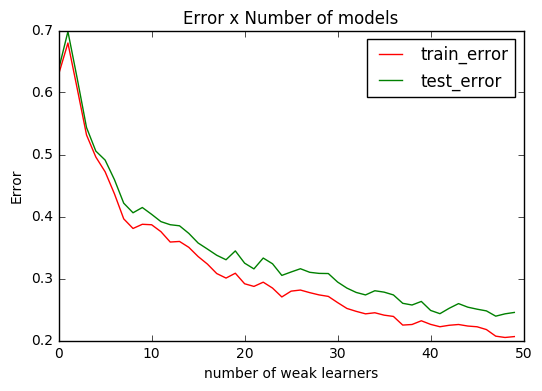

In [15]:
plt.plot(M_list, train_err_list, c= 'red', label = 'train_error', linestyle='-')
plt.plot(M_list, test_err_list, c= 'green', label = 'test_error', linestyle='-')
plt.xlabel('number of weak learners')
plt.ylabel('Error')
plt.title('Error x Number of models')
plt.legend(loc = 'upper right')
plt.show()